In [1]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import *
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile
import shutil
import numbers


In [2]:
path_data = Path('/DATA/WAMRI/salk/uri')
path_czi_data = path_data/'Airyscan_processed_data_from_the_server'
path_tile_hr = path_data/'tile_hr'
path_tile_lr = path_data/'tile_lr'
path_models = path_data/'models'
path_test_lr = path_data/'test_imgs'
path_test2_lr = path_data/'newimg'
path_test3_lr = path_data/'Image_restoration_data/train_LR'


path_tile_hr.mkdir(exist_ok=True)
path_tile_lr.mkdir(exist_ok=True)

In [3]:
fn = next(path_czi_data.iterdir())

In [4]:
def get_czi_shape_info(czi):
    shape = czi.shape
    axes = czi.axes
    axes_dict = {axis:idx for idx,axis in enumerate(czi.axes)}
    shape_dict = {axis:shape[axes_dict[axis]] for axis in czi.axes}
    return axes_dict, shape_dict


def build_index(axes, ix_select):
    idx = [ix_select.get(ax, 0) for ax in axes]
    return tuple(idx)

def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return mi, ma, normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)
    return x

def denormalize_mi_ma(x, mi, ma, dtype=np.float32):
    alpha = ma - mi
    beta = mi
    return ( alpha*x+beta ).astype(dtype,copy=False)

def draw_tile(img_norm, tile_sz):
    tile_sz = listify(tile_sz,2)
    loc = (random.randint(0,img_norm.shape[0]), random.randint(0,img_norm.shape[1]))
    shift_0 = min(0, img_norm.shape[0] - (loc[0]+tile_sz[0]))
    shift_1 = min(0, img_norm.shape[1] - (loc[1]+tile_sz[1]))
    loc = (loc[0] + shift_0, loc[1] + shift_1)
    tile = img_norm[loc[0]:(loc[0]+tile_sz[0]), loc[1]:(loc[1]+tile_sz[1])]
    return tile

def process_czi(proc_fn, tile_sz=512, scale=4, num_tiles=10, pmin=2, pmax=99.8, tile_ok = lambda x: True):
    with czifile.CziFile(proc_fn) as proc_czf:
        proc_axes, proc_shape = get_czi_shape_info(proc_czf)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        x,y = proc_shape['X'], proc_shape['Y']
        data = proc_czf.asarray()
        for channel in range(channels):
            depth = depths // 2
            idx = build_index(proc_axes, {'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx]
            img_min ,img_max, img_norm = normalize(img, clip=True)
            for tile_num in range(num_tiles):
                tile = draw_tile(img_norm, tile_sz)
                save_proc_fn = path_tile_hr/f'{proc_fn.stem}_{channel:02d}_{depth:03d}_{tile_num:03d}.tif'
                pimg = PIL.Image.fromarray(tile)
                pimg.save(save_proc_fn)
                cur_size = pimg.size
                new_size = (cur_size[0]//scale, cur_size[1]//scale)
                pimg.resize(new_size, resample=PIL.Image.BICUBIC).save(path_tile_lr/save_proc_fn.name)

In [5]:
# for fn in progress_bar(list(path_czi_data.iterdir())):
#      img = process_czi(fn)

In [6]:
def get_basename(x):
    return x.name

base_names = list(set([get_basename(x) for x in list(path_tile_lr.iterdir())]))
train_names, valid_names = random_split(0.15, base_names)
valid_names = list(valid_names[0])

def is_validation_basename(x):
    return x.name in valid_names

def lr_to_hr_fn(x):
    return path_tile_hr/x.name

In [7]:
src = (GrayImageItemList
       .from_folder(path_tile_lr, '*.tif', label_class=GrayImageItemList)
       .split_by_valid_func(is_validation_basename)
       .label_from_func(lr_to_hr_fn))

In [8]:
def charbonnier_loss(inputs, targets):
    eps = 1e-6;
    d = inputs - targets
    e = torch.sqrt(d**2 + eps)
    return e.mean()


class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)
    
    
class Blur(nn.Module):
    def __init__(self):
        super().__init__()
        self.smoothing = GaussianSmoothing(1, 5, 1)
        self.pad = nn.ReflectionPad2d(2)
        
    def forward(self, input):
        return self.smoothing(self.pad(input))

In [9]:
loss = charbonnier_loss
#loss = F.mse_loss
scale=4
model = DBPNLL(num_channels=1, base_filter=8, feat = 256, num_stages=10, scale_factor=scale)
#model = nn.Sequential(model, Blur())

#model = DBPNLL(num_channels=1, base_filter=16, feat = 256, num_stages=10, scale_factor=scale)
model = nn.DataParallel(model, [0,1,2,3])

In [10]:
# sz_lr = 512//4
# scale,bs = 4,16
# sz_hr = sz_lr*scale

# learn = build_learner(model, bs, sz_lr, sz_hr, src, loss=loss, model_dir=path_models) #, callback_fns=LossMetrics)
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
sz_lr = 512//4
scale,bs = 4,16
sz_hr = sz_lr*scale
epochs, lr = 10, 2e-3
learn = batch_learn(model, bs, sz_lr, sz_hr, lr, epochs, src, 
                    save='tile_1.0_small', 
                    loss=loss, model_dir=path_models)

In [11]:
def my_pred(self, item:ItemBase, **kwargs):
    self.callbacks.append(RecordOnCPU())
    batch = self.data.one_item(item)
    batch = to_half(batch)
    res = self.pred_batch(batch=batch)
    pred = res[0]
    x = self.callbacks[-1].input
    x = x.float()
    pred = pred.float()
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False): pred = self.data.denorm(pred)
    self.callbacks = self.callbacks[:-1]
    ds = self.data.single_ds
    pred = ds.y.analyze_pred(pred, **kwargs)
    out = ds.y.reconstruct(pred, ds.x.reconstruct(x[0])) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
    return out, pred, res[0]

In [20]:
test_fns = list(path_test_lr.iterdir())
lil = []
big = []
for fn in test_fns:
    learn = None
    gc.collect()
    img = open_grayscale(fn)
    imax,imin, inorm = normalize(img.data.numpy())
    img = Image(tensor(inorm))
    scale,bs = 4,4
    sz_lr = max(img.shape)
    sz_lr = min(int(sz_lr), 512)
    sz_hr = sz_lr*scale
    print(sz_lr, sz_hr)
    data = get_data(src, bs, sz_lr, sz_hr)
    learn = Learner(data, model, loss_func=F.mse_loss, model_dir=path_models).to_fp16().load('tile_1.0_small_best')
    a,b,c = my_pred(learn, img)
    img_data = a.data[0:1,:,:].numpy()
    #img_data = denormalize_mi_ma(img_data, imin, imax)
    img_big = Image(tensor(img_data))
    lr_fn = Path(fn.stem + '_LR.png')
    img.save(lr_fn)
    hr_fn = Path(fn.stem + '_SR.png')
    img_big.save(hr_fn)
    lil.append(img)
    big.append(img_big)
    print(lr_fn, hr_fn)

512 2048
Image 22 Block 1.czi - Image 22 Block 1 #18_5_LR.png Image 22 Block 1.czi - Image 22 Block 1 #18_5_SR.png
512 2048
Mito_confocal_lr_LR.png Mito_confocal_lr_SR.png
512 2048
C2-low res confocal mito and actin 4-1_LR.png C2-low res confocal mito and actin 4-1_SR.png
506 2024
Mitochondria_lr_LR.png Mitochondria_lr_SR.png
503 2012
lr_LR.png lr_SR.png
512 2048
C1-low res confocal mito and actin 4-1_LR.png C1-low res confocal mito and actin 4-1_SR.png
225 900
Neuron_RGB_lr_LR.png Neuron_RGB_lr_SR.png
512 2048
Denoised_actin_lr_LR.png Denoised_actin_lr_SR.png


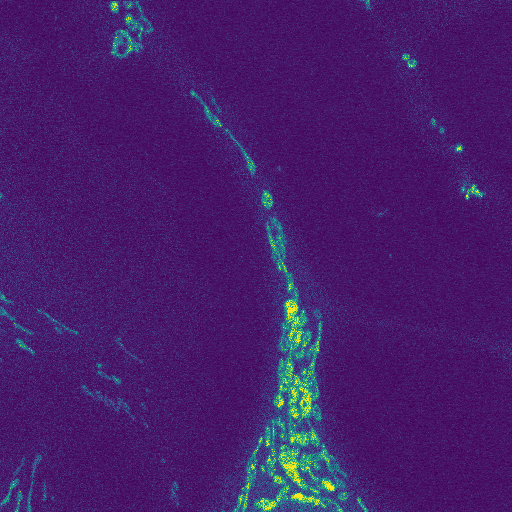

In [21]:
idx=0
l,b = lil[idx], big[idx]
l

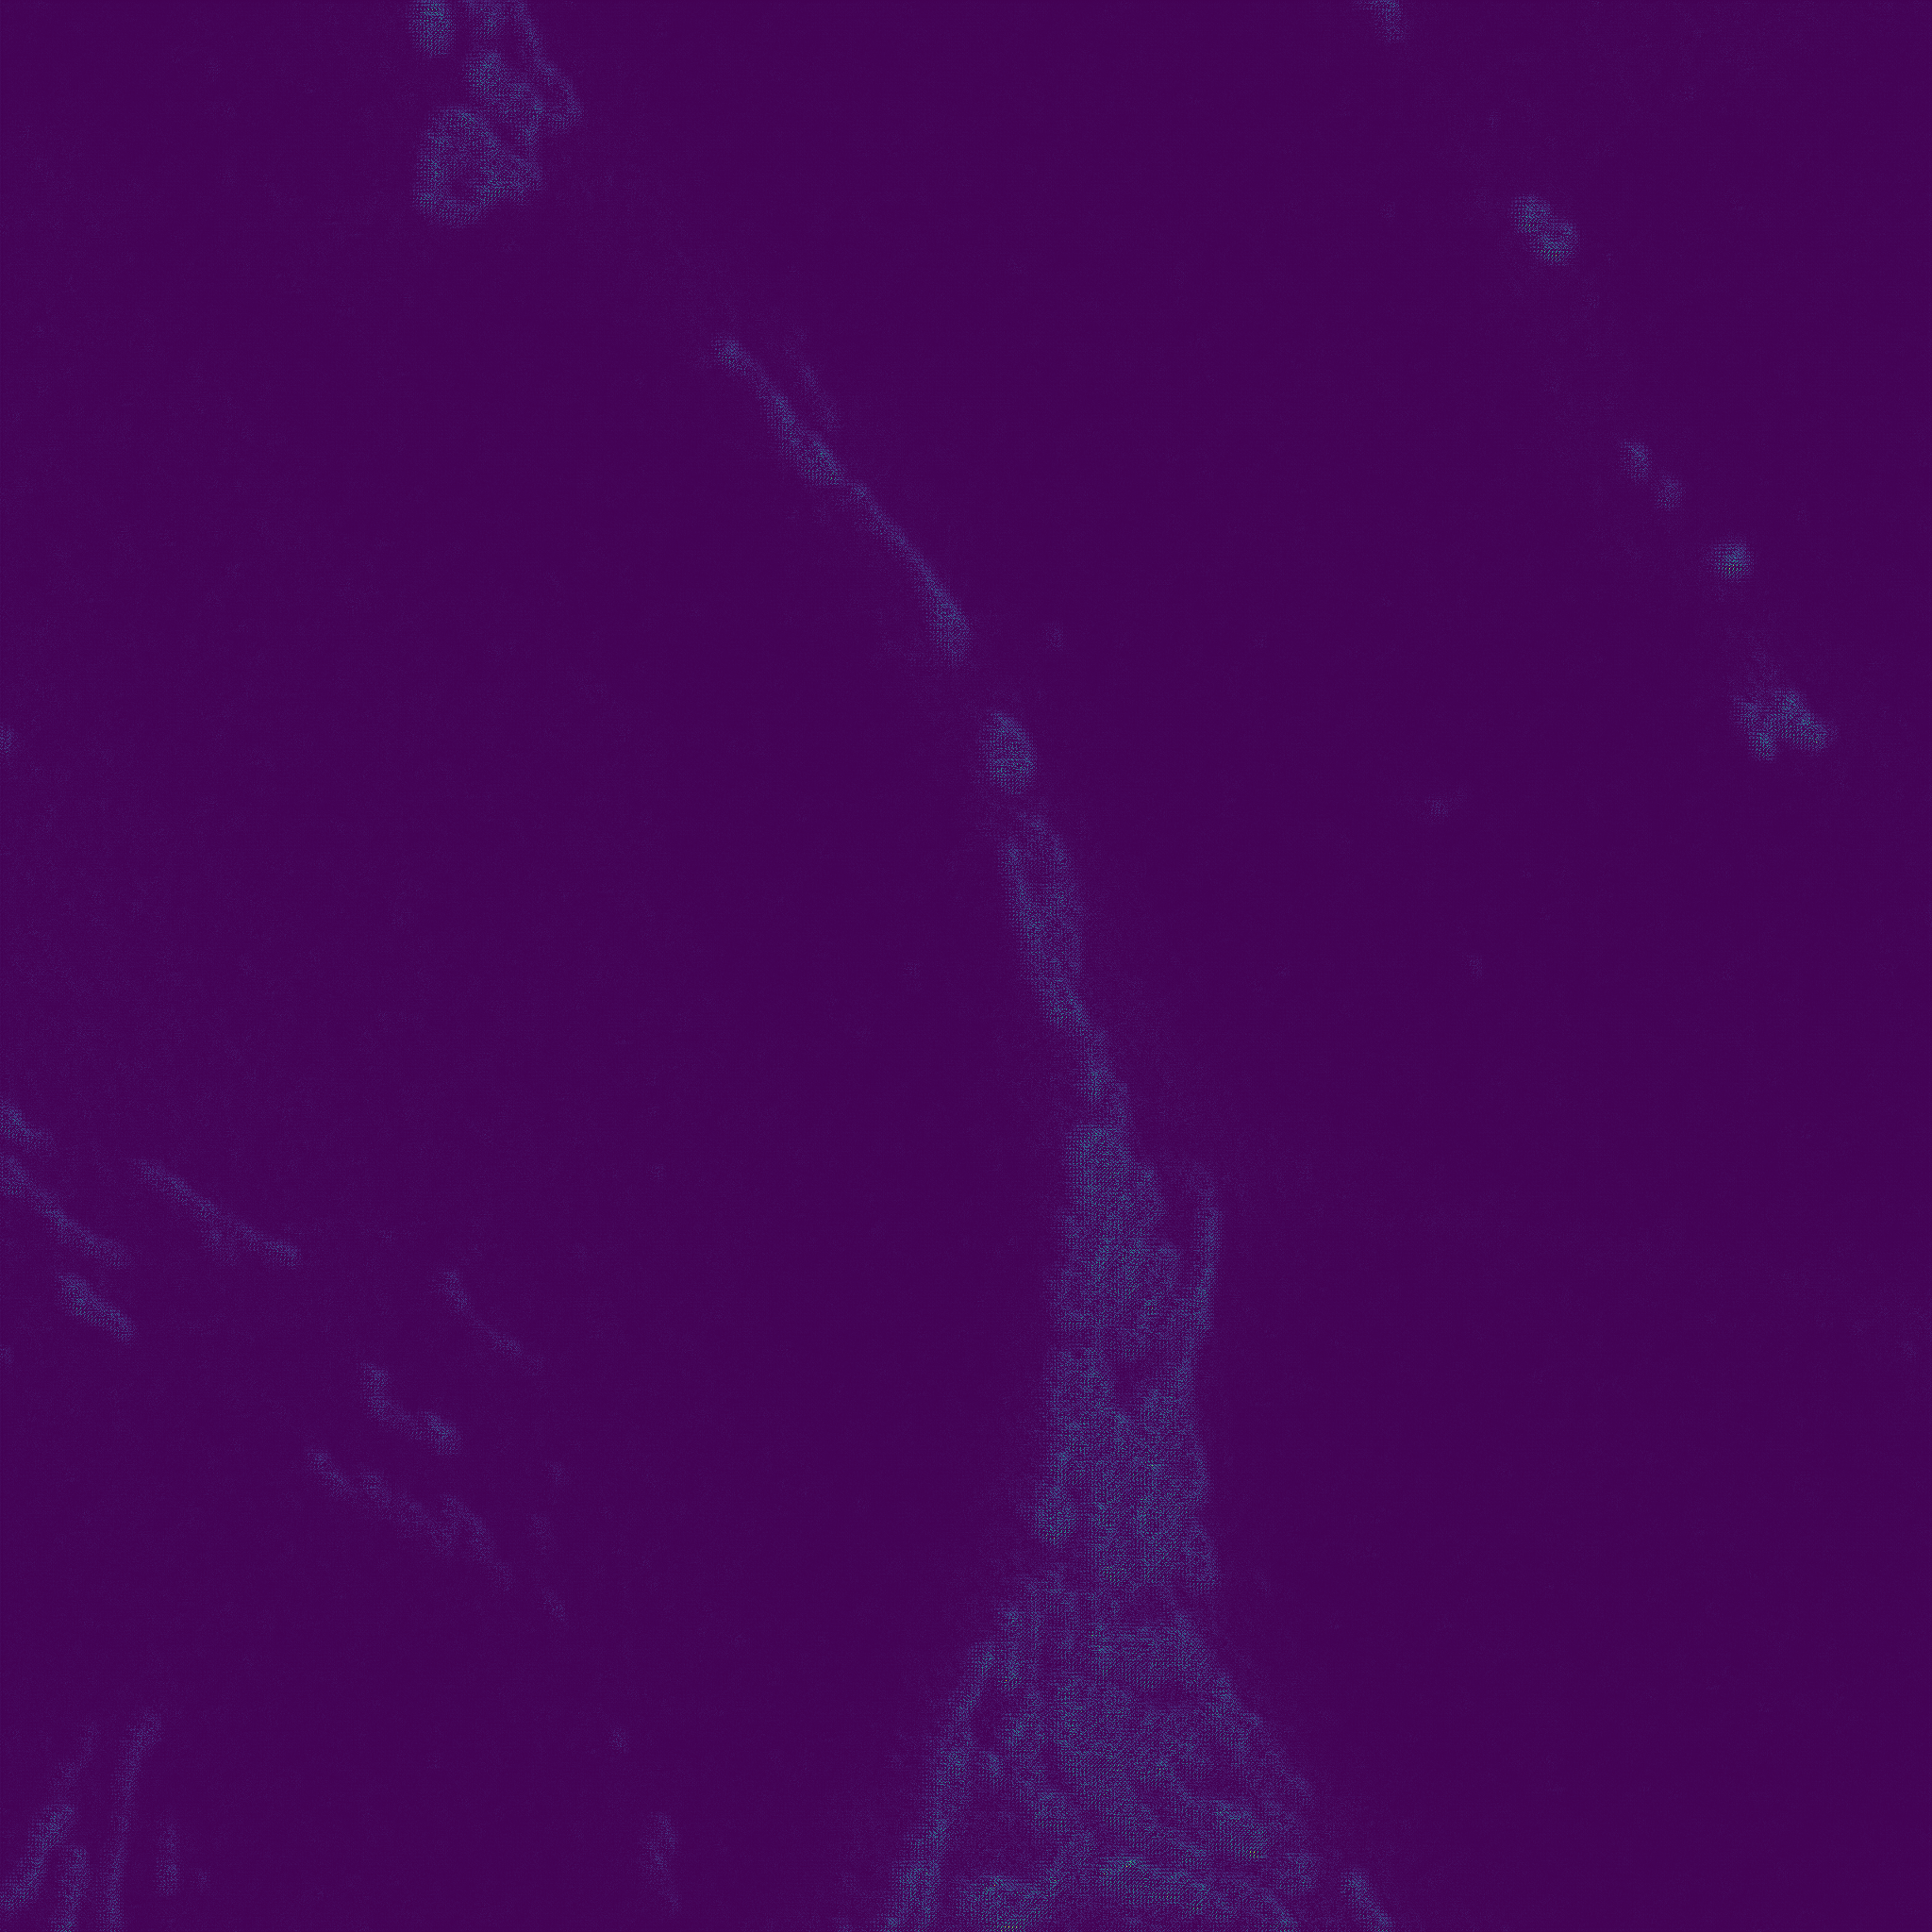

In [22]:
b

In [23]:
hr_test = open_grayscale('/home/fredmonroe/repos/salk/uri/Image 22 Block 2_Airyscan Processing.czi - Image 22 Block 2_Airyscan Processing #18_5.tif')

In [24]:
bsmaller = Image(b.data[:,12:2036, 12:2036])

In [25]:
F.mse_loss(bsmaller.data, hr_test.data)

tensor(0.0154)

In [26]:
psnr(bsmaller.data, hr_test.data)

tensor(18.1110)

In [27]:
ssim.ssim(bsmaller.data[None], hr_test.data[None])

tensor(0.4931)

In [29]:
train_hr = Path('/DATA/WAMRI/salk/uri/Image_restoration_data/train_HR/')
train_lr = Path('/DATA/WAMRI/salk/uri/Image_restoration_data/train_LR/')

def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

def match_hr_fn(x):
    return hr_names_by_id[pull_id(x.name)]

lr_names_full = list(train_lr.glob('*.tif'))
lr_names_full.sort()
hr_names_by_id = {pull_id(hrfn.name):hrfn for hrfn in train_hr.glob('*.tif')}

In [37]:
lr_to_hr = {lr_name.name:hr_names_by_id[pull_id(lr_name.name)].name for lr_name in lr_names_full}

In [63]:
for lrname, hrname in lr_to_hr.items():
    lrh, lrw = open_grayscale(train_lr/lrname).shape[1:3]
    hrh, hrw = open_grayscale(train_hr/hrname).shape[1:3]
    scale = 4
    offset_h = (lrh*scale-hrh) // (2*scale)
    offset_w = (lrw*scale-hrw) // (2*scale)
    lr_crop = 
    

3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3


KeyboardInterrupt: 

In [57]:
hrh-lrh

-24